### 来自bit.ly的1.usa.gov数据

从生成.gov或.mil短链接的用户那里收集来的匿名数据，文件中的格式为JSON

In [1]:
import json
path='ch02/usagov_bitly_data2012-03-16-1331923249.txt'
#列表推导式，将文件的每行存入records字典中
records=[json.loads(line) for line in open(path)]

records[0]

{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
 'al': 'en-US,en;q=0.8',
 'c': 'US',
 'cy': 'Danvers',
 'g': 'A6qOVH',
 'gr': 'MA',
 'h': 'wfLQtf',
 'hc': 1331822918,
 'hh': '1.usa.gov',
 'l': 'orofrog',
 'll': [42.576698, -70.954903],
 'nk': 1,
 'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
 't': 1331923247,
 'tz': 'America/New_York',
 'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991'}

In [2]:
#tz为时区
records[0]['tz']

'America/New_York'

### 用pandas对时区进行计数

In [4]:
from pandas import DataFrame,Series
import pandas as pd
import numpy as np

frame=DataFrame(records)
frame['tz'][:10]

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
5     America/New_York
6        Europe/Warsaw
7                     
8                     
9                     
Name: tz, dtype: object

frame['tz']所返回的Series对象有一个value_counts()方法用于计数

In [5]:
tz_counts=frame['tz'].value_counts()

tz_counts[:10]

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: tz, dtype: int64

然后对记录中未知或缺失的时区填上一个替代值：

In [6]:
clean_tz=frame['tz'].fillna('Missing')
clean_tz[clean_tz=='']='Unknow'

tz_counts=clean_tz.value_counts()
tz_counts[:10]

America/New_York       1251
Unknow                  521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

利用tz_counts对象的plot方法即可得到一张水平条形图：

Populating the interactive namespace from numpy and matplotlib


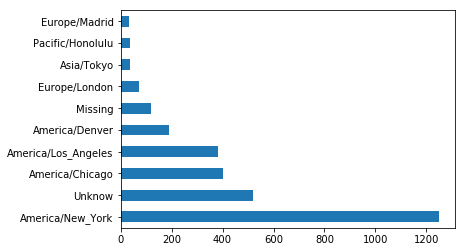

In [8]:
%pylab inline

tz_counts[:10].plot(kind='barh')

a字段中还含有执行URL短缩操作的浏览器，设备，应用程序的相关信息：

In [10]:
frame['a'][[1,50,51]]

1                                GoogleMaps/RochesterNY
50    Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/...
51    Mozilla/5.0 (Linux; U; Android 2.2.2; en-us; L...
Name: a, dtype: object

我们可以将这种字符串的第一节（浏览器）分离出来并得到另外一份用户行为摘要：

In [11]:
results=Series([x.split()[0]] for x in frame.a.dropna())

results[:5]

0               [Mozilla/5.0]
1    [GoogleMaps/RochesterNY]
2               [Mozilla/4.0]
3               [Mozilla/5.0]
4               [Mozilla/5.0]
dtype: object

### 现在我要对Windows和非Windows用户对时区统计信息进行分解


假定只要‘agent’字符中含有“Windows”就认为该用户为Windows用户，我们先将缺失值从数据中移除：

In [13]:
cframe=frame[frame.a.notnull()]
oprating_system=np.where(cframe['a'].str.contains('Windows'),'Windows','Not Windows')

oprating_system[:5]

array(['Windows', 'Not Windows', 'Windows', 'Not Windows', 'Windows'], 
      dtype='<U11')

接下来就可以根据时区和新得到的操作系统列表对数据进行分组了：

In [14]:
by_tz_os = cframe.groupby(['tz',oprating_system])

然后通过size对分组结果进行计数，并利用unstack对计数结果进行重塑：

In [15]:
agg_counts = by_tz_os.size().unstack().fillna(0)

agg_counts[:10]

,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0
Africa/Lusaka,0.0,1.0
America/Anchorage,4.0,1.0
America/Argentina/Buenos_Aires,1.0,0.0
America/Argentina/Cordoba,0.0,1.0


最后我们来选取最常出现的时区，为了达到这个目的，先根据agg_counts中的行数构造一个间接索引数组：

In [16]:
#用于按升序排列
indexer = agg_counts.sum(1).argsort()

indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

然后通过take按照这个顺序截取最后10行：

In [18]:
count_subset = agg_counts.take(indexer)[-10:]

count_subset

,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


也可以生成一张条形图来使结果更加明了，使用stacked=True来生成一张堆积条形图：

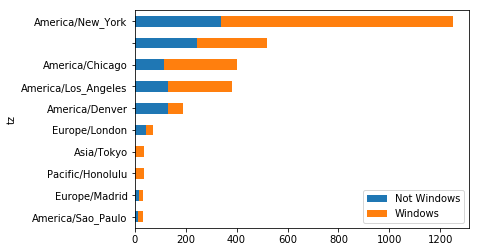

In [20]:
count_subset.plot(kind='barh',stacked=True)

由于在这张图中不太容易看清较小分组中Windows用户的相对比例，因此我们可以将各行规范化为“总数为1”并重新绘图：

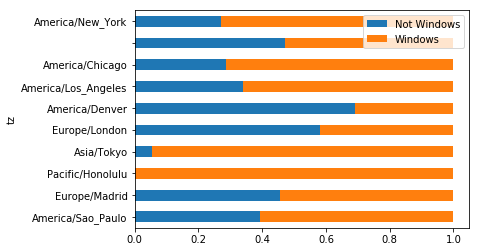

In [21]:
normed_subset = count_subset.div(count_subset.sum(1),axis=0)

normed_subset.plot(kind='barh',stacked=True)